In [2]:
import sys
import glob
import h5py
import pyart
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from analysis import *
import matplotlib.pyplot as plt

In [3]:
win=100
nbasis=15
exp = 'nat8b'
dataset = 'cohort'

spectrograms = pd.read_csv(f"../build/{exp}/spectrograms.csv", index_col=[0,1])
stim_info = pd.read_csv(f"../inputs/stimuli/{exp}-info.csv")
motifs = stim_info.motif.unique()
gap_times = stim_info[stim_info.type=='gap'].groupby(['motif','gap']).first()[['gap_start', 'gap_stop']]
gaplocs = stim_info.gap.unique()
dsetdata = []
for h5file in glob.glob(f"../build/{exp}/**_delemb_win{win}_basis{nbasis}.h5"):
    dsetdata.append(pd.read_hdf(h5file, key='Induction'))
responses = pd.concat(dsetdata, axis=1)
models = joblib.load(f"../output/{exp}/{dataset}_PLS_models.pkl")

## Example of projecting novel (untrained) data onto latent dimensions

In [5]:
m = 'nat8mk5'
g = 2
model = models[m]
tmax = spectrograms.loc[bname(m, 'C', None)].index.max()
ga, gb = gap_times.loc[m].loc[g].astype(int)

conditions = ['C','G','CB','GB','CM','GM','N']
xscores = {}
yscores = {}

cstim = spectrograms.loc[bname(m, 'C', g, gtype)]

for c in conditions:
    stim = bname(m, c, g, gtype)
    X, Y = model.transform(
        X = responses.loc[stim].loc[cstim.index],
        Y = spectrograms.loc[stim].loc[cstim.index] 
    )
    xscores[c] = X
    yscores[c] = Y

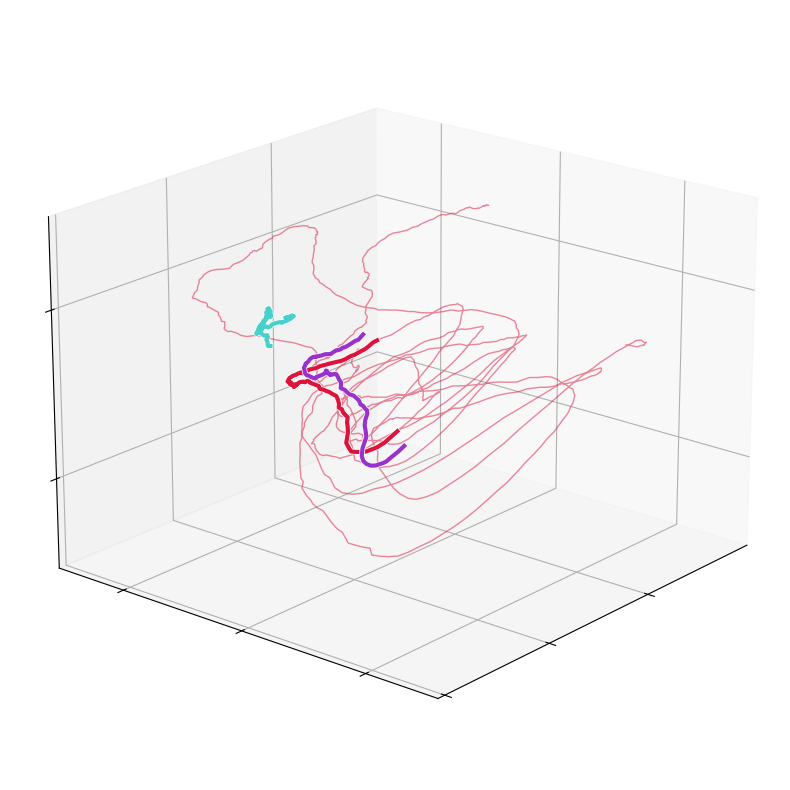

In [34]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
for c in ['GB', 'CB', 'GM']:
    lw = 3 
    ls = '-'
    if c=='GB':
        ax.plot(
            xscores[c][:, 0],
            xscores[c][:, 1],
            xscores[c][:, 2],
            alpha=0.5,
            color=colors[c],
            lw = 1
        )
    ax.plot(
        xscores[c][ga:gb, 0],
        xscores[c][ga:gb, 1],
        xscores[c][ga:gb, 2],
        alpha=1,
        lw=lw+1,
        ls=ls,
        color='white'
    )
    ax.plot(
        xscores[c][ga:gb, 0],
        xscores[c][ga:gb, 1],
        xscores[c][ga:gb, 2],
        alpha=1,
        lw=lw,
        ls=ls,
        color=colors[c]
    )
ax.set_ylim(-0.5, 2.5)
ax.set_yticks([0,1,2],[])

ax.set_xlim(0,3)
ax.set_xticks([1,2,3],[])

ax.set_zlim(-1.5, 0.5)
ax.set_zticks([-1,0],[])
plt.setp(ax.spines.values(), lw=3, color='black')

ax.view_init(elev=20, azim=40, roll=0)

## Reconstructed (Predicted) Spectrogram

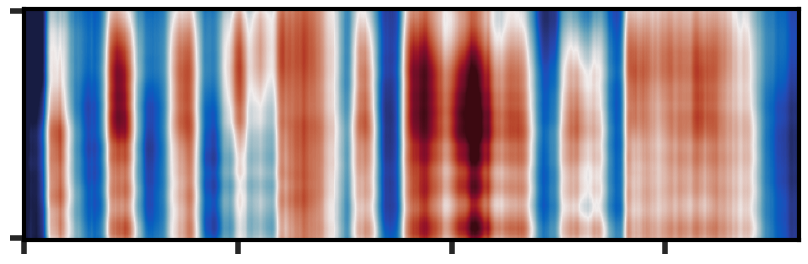

In [35]:
sns.set_style('white')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['xtick.minor.size'] = 6
plt.rcParams['xtick.minor.width'] = 2

plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 4
plt.rcParams['ytick.minor.size'] = 6
plt.rcParams['ytick.minor.width'] = 2

recon = model.transform(
    X = responses.loc[bname(m, 'GB', g)].loc[cstim.index],
)
ax = plt.figure(figsize=(10,3)).add_subplot()
ax.imshow(recon.T.iloc[::-1], cmap=cmap, vmin=0, vmax=2.7, aspect='auto')
ax.set_xticks([0,300, 600, 900], [])
ax.set_yticks([0,49], [])
plt.setp(ax.spines.values(), lw=3, color='black');